importing packages & files

In [442]:
# import packages, files

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

census_df = pd.read_excel('../Data/census_data.xls', sheet_name='est22ALL', skiprows=3, engine='xlrd')

graduation_df = pd.read_excel('../Data/graduation_rates.xlsx', sheet_name='Data')

library_df = pd.read_excel('../Data/library_data.xlsx', sheet_name='PLS_FY22_AE_pud22i')

create primary keys for joining

In [443]:
# align dataframes for merging across counties
# using keys "state", "county"
# no trailing whitespace, all lowercase

# graduation file needs to have state extracted, words like "county" removed

graduation_df['STATE'] = graduation_df['COUNTY'].str.extract(r",\s*([A-Z]{2})$")
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*County,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Municipality,?\s*[A-Z]{2}$", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Borough/.*", "", regex=True)
graduation_df['COUNTY'] = graduation_df['COUNTY'].str.replace(r"\s*Census( Area)?", "", regex=True)


for col in graduation_df.columns:
    if graduation_df[col].dtype == 'object': 
        graduation_df[col] = graduation_df[col].str.lower().str.strip()
        
# library file needs to be made lowercase

library_df.rename(columns={'STABR': 'STATE', 'CNTY': 'COUNTY'}, inplace=True)
library_df['STATE'] = library_df['STATE'].str.lower().str.strip()
library_df['COUNTY'] = library_df['COUNTY'].str.lower().str.strip()

# census file needs to have state extracted, words like "county" removed

census_df.rename(columns={'Postal Code': 'STATE', 'Name': 'COUNTY'}, inplace=True)
census_df['COUNTY'] = census_df['COUNTY'].str.replace(r"\s*(County|Borough|Municipality|Census( Area)?)", "", regex=True)

census_df['STATE'] = census_df['STATE'].str.lower().str.strip()
census_df['COUNTY'] = census_df['COUNTY'].str.lower().str.strip()

rename & select columns

In [444]:
# select and rename relevant columns before merging

graduation_df.columns = graduation_df.columns.astype(str)

print(graduation_df.columns)

graduation_df = graduation_df[['STATE', 'COUNTY', '2022-01-01 00:00:00']]
graduation_df.rename(columns={'2022-01-01 00:00:00': 'grad_rate'}, inplace=True)

library_df = library_df[['STATE', 'COUNTY', 'CNTYPOP', 'VISITS', 'REGBOR', 'TOTINCM', 'TOTPRO', 'TOTSTAFF', 'TOTCIR', 'CENTLIB', 'BRANLIB']]

# Identify the columns to transform
columns_to_lower = library_df.columns[2:]  # From 'POPU_LSA' onwards

# Convert these columns to lowercase
library_df.rename(columns={col: col.lower() for col in columns_to_lower}, inplace=True)

# drop blank columns

census_df = census_df[(census_df['90% CI Upper Bound.6'] != ".") & 
                      (census_df['90% CI Lower Bound.6'] != ".")]

# Ensure columns are cast to float before subtraction
census_df['90% CI Upper Bound.6'] = census_df['90% CI Upper Bound.6'].astype(float)
census_df['90% CI Lower Bound.6'] = census_df['90% CI Lower Bound.6'].astype(float)

# create variable "income_range"
census_df['income_range'] = census_df['90% CI Upper Bound.6'] - census_df['90% CI Lower Bound.6']

census_df = census_df[['STATE', 'COUNTY', 'Poverty Percent, Age 5-17 in Families', 'Median Household Income', 'income_range']]

census_df.rename(columns={'Poverty Percent, Age 5-17 in Families':'poverty_percent', 'Median Household Income':'med_income'}, inplace=True)

print('lib')
print(library_df)
print('census')
print(census_df)
print('grad')
print(graduation_df)

Index(['COUNTY', 'CODE', '2010-01-01 00:00:00', '2011-01-01 00:00:00',
       '2012-01-01 00:00:00', '2013-01-01 00:00:00', '2014-01-01 00:00:00',
       '2015-01-01 00:00:00', '2016-01-01 00:00:00', '2017-01-01 00:00:00',
       '2018-01-01 00:00:00', '2019-01-01 00:00:00', '2020-01-01 00:00:00',
       '2021-01-01 00:00:00', '2022-01-01 00:00:00', 'STATE'],
      dtype='object')
lib
     STATE             COUNTY  cntypop  visits  regbor  totincm  totpro  \
0       ak    kenai peninsula    59767    5127    1950    71874     150   
1       ak          anchorage   288121  261807  123846  9357471     758   
2       ak             denali     1593     421     138    13885      -1   
3       ak             bethel    18557   12817    2062   138115      80   
4       ak  matanuska-susitna   110686   27063    2867   417502     249   
...    ...                ...      ...     ...     ...      ...     ...   
9243    wy           sublette     8697   96858    4525  1077591     689   
9244    wy  

merge columns. left joined on graduation data

In [445]:
# First, left join graduation_df (left) with library_df (right)
merged_df = graduation_df.merge(library_df, on=['STATE', 'COUNTY'], how='left')

# Then, left join the result with census_df (right)
merged_df = merged_df.merge(census_df, on=['STATE', 'COUNTY'], how='left')

print(merged_df)
# Select columns to convert (exclude 'STATE' and 'COUNTY')
columns_to_convert = merged_df.columns.difference(['STATE', 'COUNTY'])

# Convert selected columns to float
merged_df[columns_to_convert] = merged_df[columns_to_convert].astype(float)

# Verify the conversion
print(merged_df.dtypes)

# Count rows with null values
rows_with_nulls = merged_df.isnull().any(axis=1).sum()
# Count rows without null values
rows_without_nulls = (~merged_df.isnull().any(axis=1)).sum()

print(f"Number of rows with null values: {rows_with_nulls}")
print(f"Number of rows without null values: {rows_without_nulls}")


     STATE     COUNTY  grad_rate   cntypop    visits   regbor    totincm  \
0       al    autauga       90.4   59095.0   62905.0  32024.0   663391.0   
1       al    baldwin       91.6  239294.0   10000.0   2316.0   310021.0   
2       al    baldwin       91.6  239294.0  102903.0  14589.0  1208716.0   
3       al    baldwin       91.6  239294.0  156951.0  19876.0   930410.0   
4       al    baldwin       91.6  239294.0  137258.0  16302.0  1126338.0   
...    ...        ...        ...       ...       ...      ...        ...   
9636    pr  vega baja       76.7       NaN       NaN      NaN        NaN   
9637    pr    vieques       72.3       NaN       NaN      NaN        NaN   
9638    pr   villalba       78.9       NaN       NaN      NaN        NaN   
9639    pr    yabucoa       74.8       NaN       NaN      NaN        NaN   
9640    pr      yauco       79.0   32904.0      -1.0     -1.0       -1.0   

      totpro  totstaff    totcir  centlib  branlib poverty_percent med_income  \
0     

deal with null, negative values. 


In [446]:
# deal with null columns, missing columns (imputation)
# may need more refined future approach

# Drop rows with null values
filtered_df = merged_df.dropna()

# Define the columns to check (exclude 'STATE' and 'COUNTY')
columns_to_check = filtered_df.columns.difference(['STATE', 'COUNTY'])

# Drop rows with null values in the selected columns
filtered_df = filtered_df.dropna(subset=columns_to_check)

# Drop rows with negative values in the selected columns
filtered_df = filtered_df[(filtered_df[columns_to_check] >= 0).all(axis=1)]

# Print the resulting DataFrame
print(f"Number of rows after filtering: {len(filtered_df)}")
print(filtered_df)

Number of rows after filtering: 8401
     STATE      COUNTY  grad_rate   cntypop    visits   regbor    totincm  \
0       al     autauga       90.4   59095.0   62905.0  32024.0   663391.0   
1       al     baldwin       91.6  239294.0   10000.0   2316.0   310021.0   
2       al     baldwin       91.6  239294.0  102903.0  14589.0  1208716.0   
3       al     baldwin       91.6  239294.0  156951.0  19876.0   930410.0   
4       al     baldwin       91.6  239294.0  137258.0  16302.0  1126338.0   
...    ...         ...        ...       ...       ...      ...        ...   
9555    wy  sweetwater       93.0   41614.0  222458.0  31288.0  3246411.0   
9556    wy       teton       96.0   23575.0  124903.0  17071.0  4099837.0   
9557    wy       uinta       94.4   20635.0   71067.0  11107.0   526251.0   
9558    wy    washakie       94.7    7705.0   44650.0   6850.0   316001.0   
9559    wy      weston       91.1    6745.0   25230.0   5056.0   325212.0   

      totpro  totstaff    totcir  cent

variables and description of how to handle multiplicity across counties:
- STATE, COUNTY --> primary key
- grad_rate --> high school grad rate (%)
- cntypop --> population of county (should be same across)
- visits --> num visits in year (sum across library systems in county)
- regbor --> registered users (sum across all library systems in county? problem is people can be registered in more than one library)
- locgvt --> local government revenue (sum across? needs more analysis based off imputation methods)
- totpro --> total programs (sum across library systems)
- totstaff --> total staff (sum across library systems)
- totcir --> total circulation (sum across library systems in county)
- centlib --> num central libraries in system (sum across)
- branlib --> num bran libraries in systems (sum across)
- poverty_percent --> % in poverty in county (will be same across)
- med_income --> median household income (will be same across)
- income_range --> dif in 90% upper/lower CI of household income in county (will be same across)




In [447]:
# aggregate columns according to above

# Define aggregation logic for each column
aggregation_logic = {
    'grad_rate': 'first',  # Average graduation rate
    'cntypop': 'first',  # Total population
    'visits': 'sum',  # Total visits across systems
    'regbor': 'sum',  # Total registered borrowers (note possible duplicates)
    'totincm': 'sum',  # Total revenues
    'totpro': 'sum',  # Total programs offered
    'totstaff': 'sum',  # Total staff across systems
    'totcir': 'sum',  # Total circulation
    'centlib': 'sum',  # Total number of central libraries
    'branlib': 'sum',  # Total number of branch libraries
    'poverty_percent': 'first',  # Same across rows, use first occurrence
    'med_income': 'first',  # Same across rows, use first occurrence
    'income_range': 'first'  # Same across rows, use first occurrence
}

# Group by STATE and COUNTY and apply aggregation logic
aggregated_df = filtered_df.groupby(['STATE', 'COUNTY'], as_index=False).agg(aggregation_logic)
print(aggregated_df)


     STATE                COUNTY  grad_rate   cntypop    visits    regbor  \
0       ak        aleutians east       81.0    3398.0    1196.0     136.0   
1       ak             anchorage       94.2  288121.0  261807.0  123846.0   
2       ak           bristol bay       95.0     838.0    7359.0     407.0   
3       ak                denali       96.7    1593.0    1642.0    1227.0   
4       ak  fairbanks north star       94.7   95593.0  203237.0   42522.0   
...    ...                   ...        ...       ...       ...       ...   
2538    wy            sweetwater       93.0   41614.0  222458.0   31288.0   
2539    wy                 teton       96.0   23575.0  124903.0   17071.0   
2540    wy                 uinta       94.4   20635.0   71067.0   11107.0   
2541    wy              washakie       94.7    7705.0   44650.0    6850.0   
2542    wy                weston       91.1    6745.0   25230.0    5056.0   

        totincm  totpro  totstaff    totcir  centlib  branlib  \
0       42

check for rate of missing data 

In [448]:
# check percent of column that value is zero for 
# Calculate percentage of zeros in each column
zero_percentages = {}
for col in aggregated_df.columns:
    zero_count = (aggregated_df[col] == 0).sum()
    zero_percentage = (zero_count / len(aggregated_df)) * 100
    zero_percentages[col] = zero_percentage

# Display results
for col, pct in zero_percentages.items():
    print(f"Column {col}: {pct:.2f}% zeros")

Column STATE: 0.00% zeros
Column COUNTY: 0.00% zeros
Column grad_rate: 0.00% zeros
Column cntypop: 0.00% zeros
Column visits: 0.04% zeros
Column regbor: 0.00% zeros
Column totincm: 0.00% zeros
Column totpro: 0.90% zeros
Column totstaff: 0.04% zeros
Column totcir: 0.04% zeros
Column centlib: 3.19% zeros
Column branlib: 56.27% zeros
Column poverty_percent: 0.00% zeros
Column med_income: 0.00% zeros
Column income_range: 0.00% zeros


convert relevant metrics to per capita

In [449]:
# Store original columns along with additional variables
columns_to_store = [
    'centlib', 'branlib', 'visits', 'regbor', 'totincm', 'totpro', 
    'totstaff', 'totcir', 'poverty_percent', 'med_income', 'income_range'
]
original_columns = aggregated_df[columns_to_store].copy()

# Retain cntypop for per capita conversion and future use
population_column = aggregated_df['cntypop'].copy()

# Convert to per capita by dividing each column by 'cntypop'
columns_to_convert = ['centlib', 'branlib', 'visits', 'regbor', 'totincm', 'totpro', 'totstaff', 'totcir']
for col in columns_to_convert:
    aggregated_df[col + '_per_capita'] = aggregated_df[col] / aggregated_df['cntypop']

# Drop the original columns
aggregated_df.drop(columns=columns_to_convert + ['cntypop'], inplace=True)

create correlation matrix

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\1728702138.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = aggregated_df.corr()


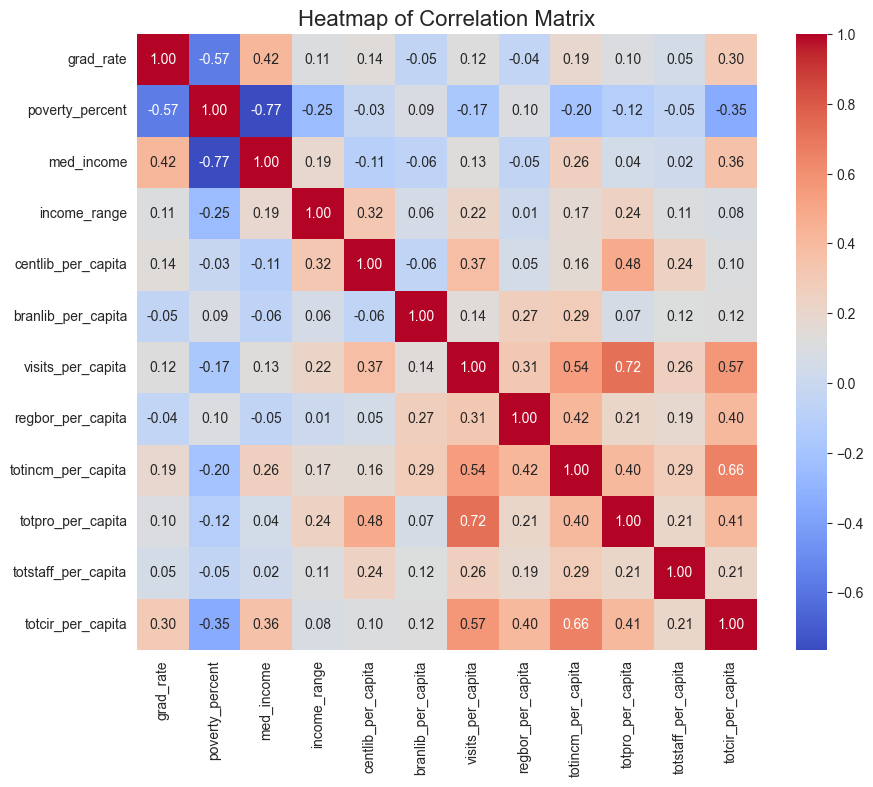

In [450]:
# Calculate the correlation matrix and print the heatmap
corr_matrix = aggregated_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix", fontsize=16)
plt.show()

plot independent variables against the grad rate

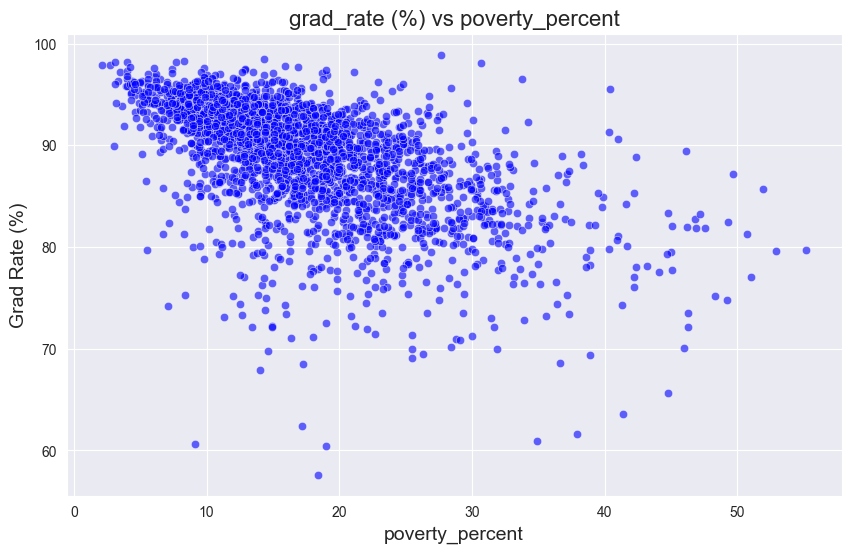

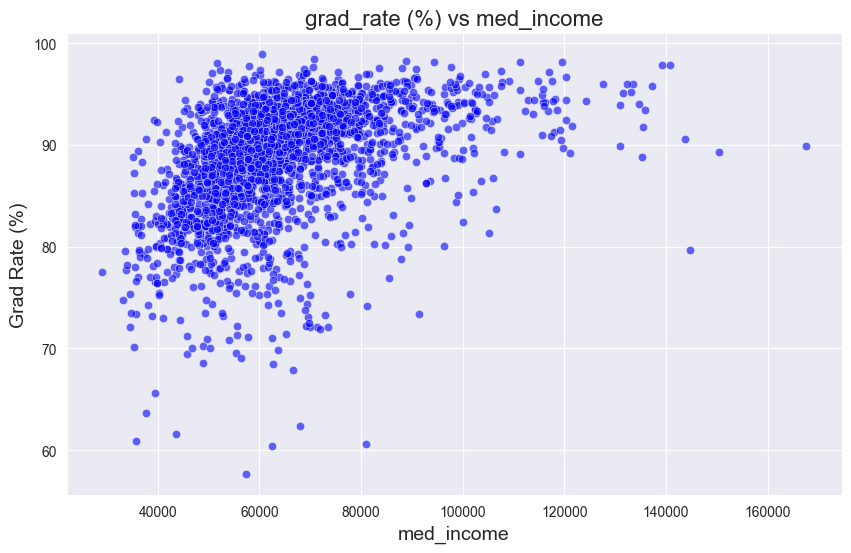

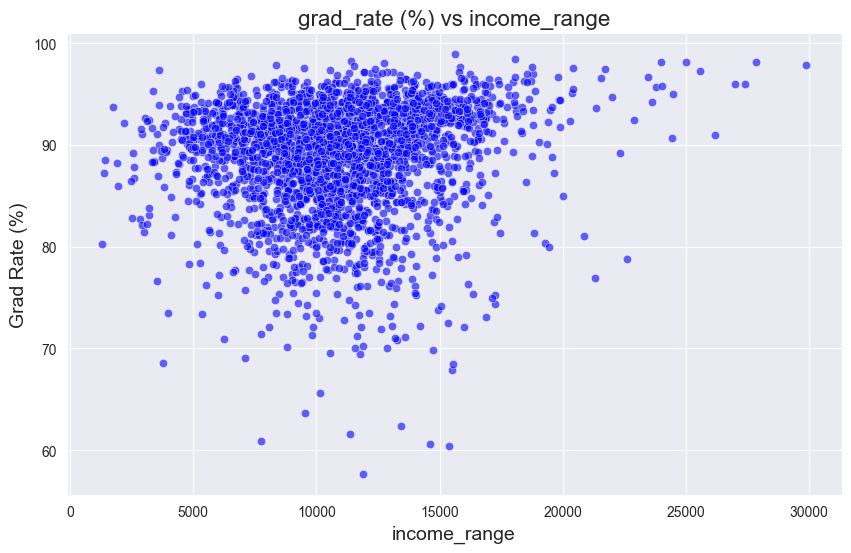

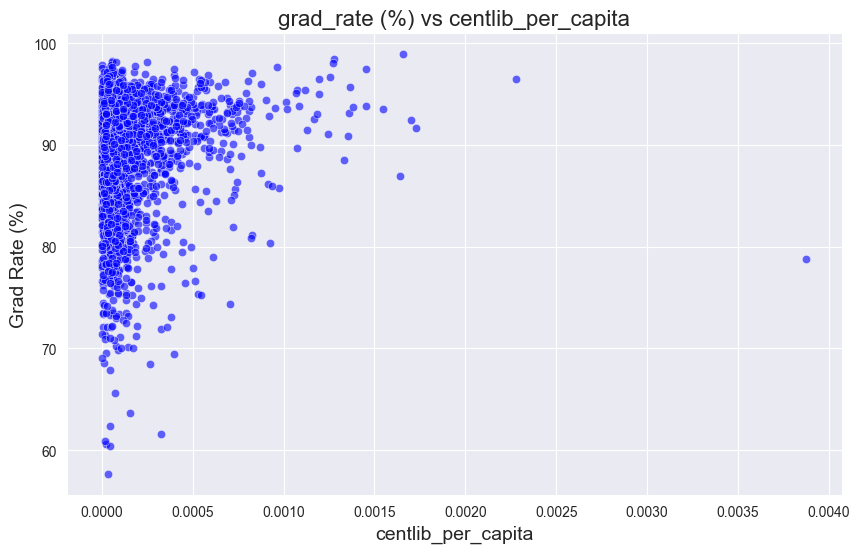

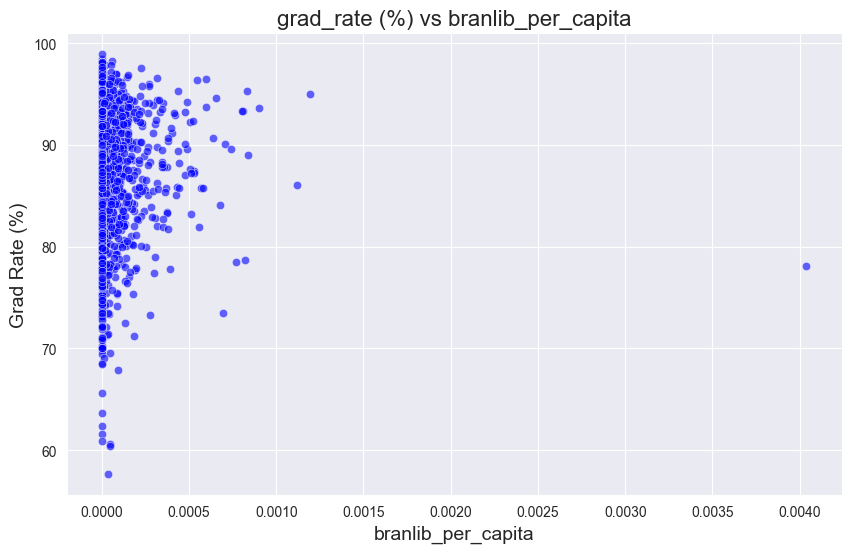

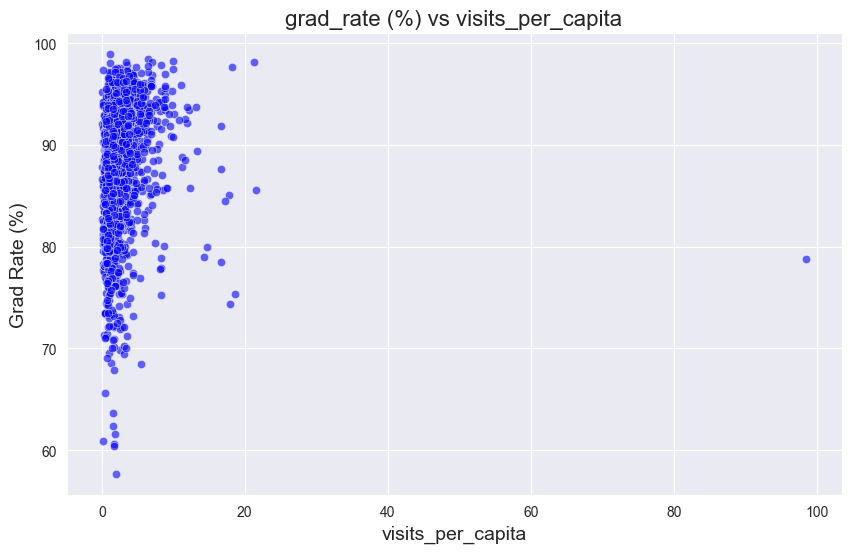

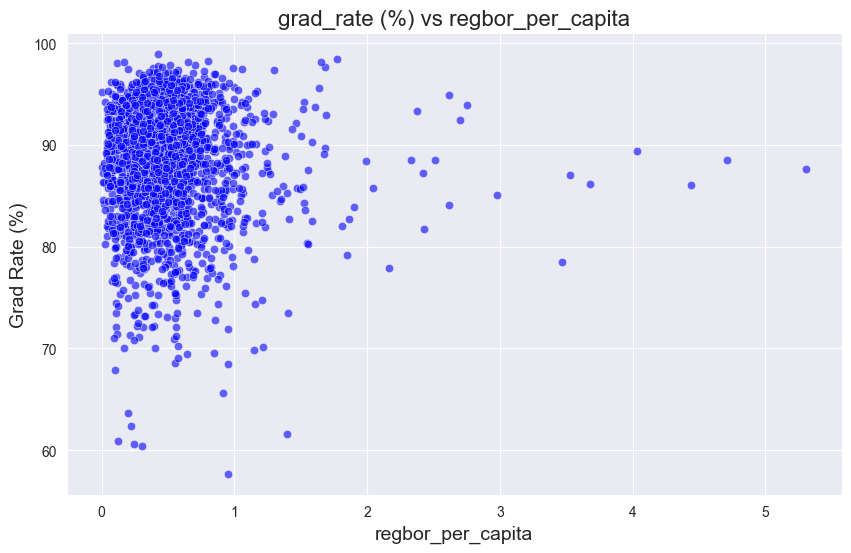

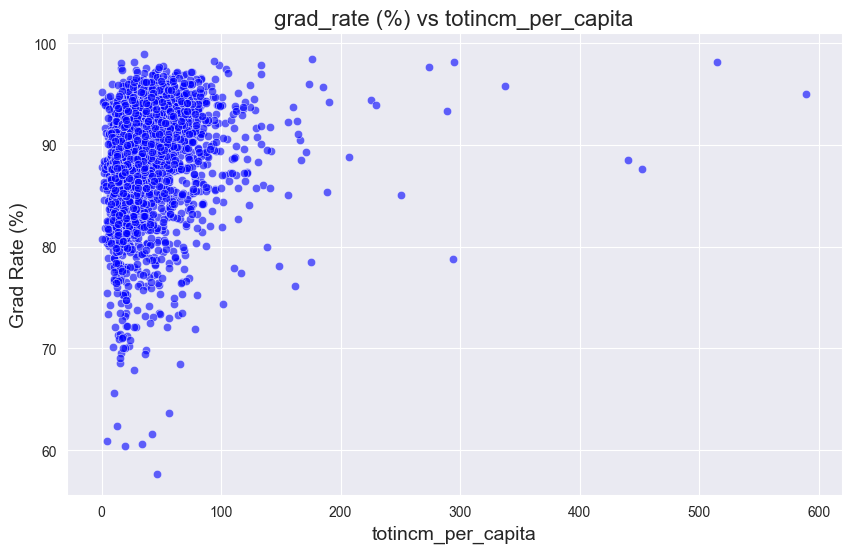

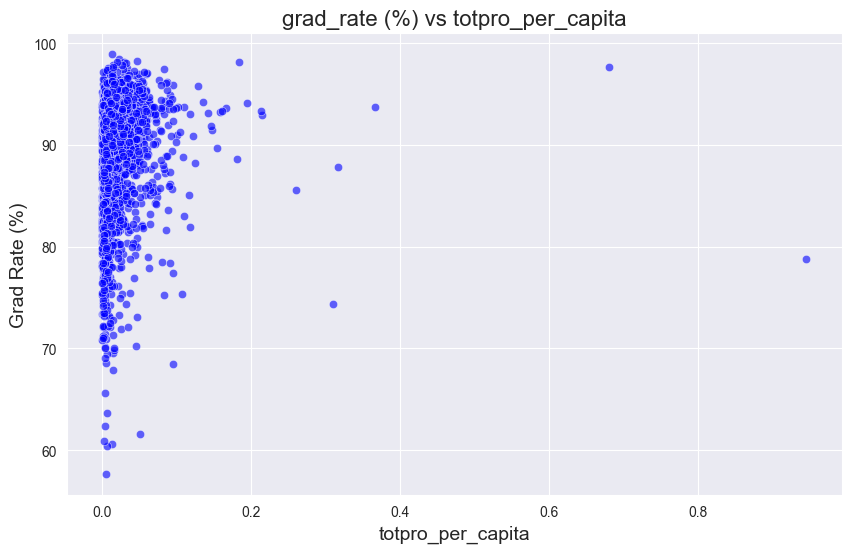

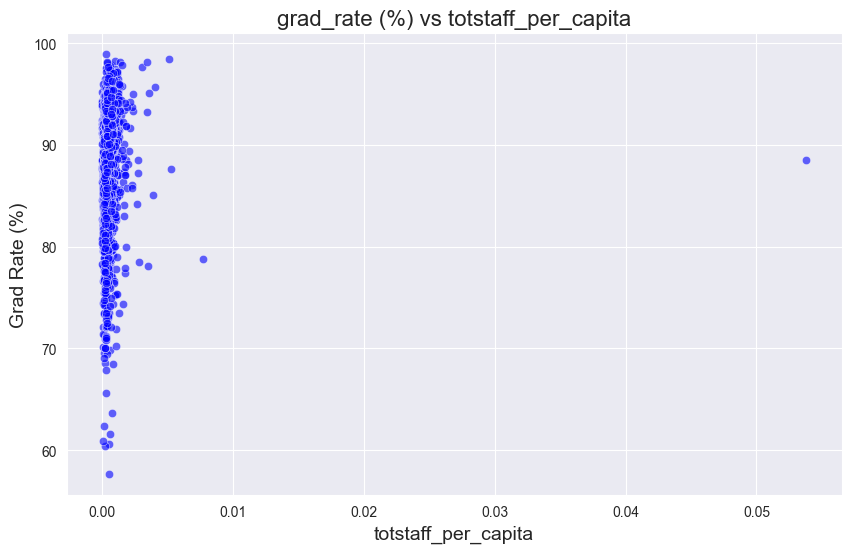

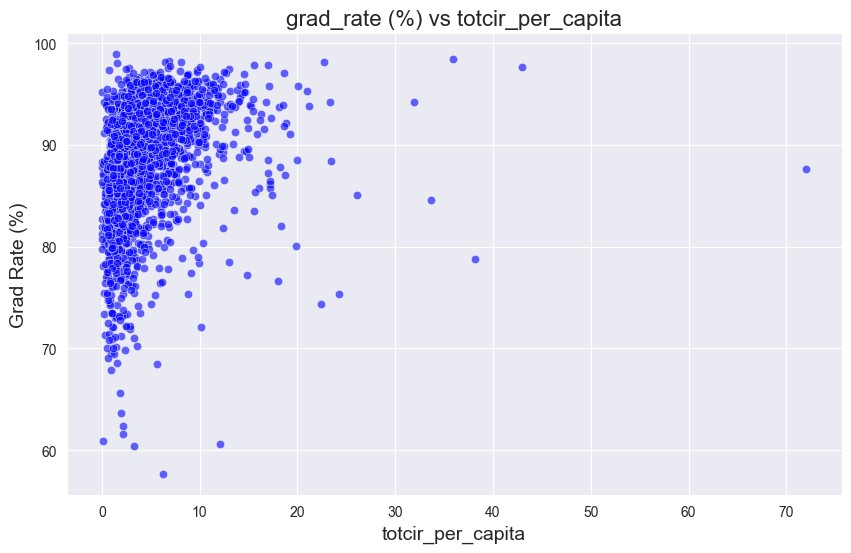

In [451]:
# exclude the dependent variable from the list of independent variables
independent_vars = aggregated_df.drop(columns=['grad_rate', 'STATE', 'COUNTY']).columns

# create scatter plots for each independent variable against grad_rate
for var in independent_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=aggregated_df, x=var, y='grad_rate', alpha=0.6, color='blue')
    plt.title(f'grad_rate (%) vs {var}', fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Grad Rate (%)', fontsize=14)
    plt.grid(True)
    plt.show()


scale data to prepare for regularized regression models

In [452]:
# select features and target variable
X = aggregated_df.drop(columns=['STATE', 'COUNTY', 'grad_rate'])  # Drop non-numerical and target
y = aggregated_df['grad_rate']

# scale the data
scaler = StandardScaler()

# split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)



perform lasso regression

In [453]:
# Lasso regression with cross-validation
lasso = LassoCV(alphas=np.logspace(-4, 4, 100), cv=20, random_state=42)
lasso.fit(X_train, y_train)

# Lasso performance
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)

lasso_train_error = mean_squared_error(y_train, lasso_train_pred)
lasso_test_error = mean_squared_error(y_test, lasso_test_pred)

print("Lasso Regression")
print(f"Best Alpha: {lasso.alpha_}")
print(f"Train Error (MSE): {lasso_train_error}")
print(f"Test Error (MSE): {lasso_test_error}")


Lasso Regression
Best Alpha: 0.08111308307896872
Train Error (MSE): 19.06829082181118
Test Error (MSE): 19.226262387944157


perform ridge regression

In [454]:
# Ridge regression with cross-validation
ridge = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=20)
ridge.fit(X_train, y_train)

# Ridge performance
ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)

ridge_train_error = mean_squared_error(y_train, ridge_train_pred)
ridge_test_error = mean_squared_error(y_test, ridge_test_pred)

print("\nRidge Regression")
print(f"Best Alpha: {ridge.alpha_}")
print(f"Train Error (MSE): {ridge_train_error}")
print(f"Test Error (MSE): {ridge_test_error}")


Ridge Regression
Best Alpha: 37.649358067924716
Train Error (MSE): 18.959892519431207
Test Error (MSE): 19.095646307120706


observe weights of ridge


In [455]:
#ridge results 
feature_names = X.columns
ridge_coefficients = ridge.coef_

ridge_weights = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coefficients
})
ridge_weights = ridge_weights.reindex(ridge_weights['Coefficient'].abs().sort_values(ascending=False).index)

print("Ridge Regression Coefficients:")
print(ridge_weights)


Ridge Regression Coefficients:
                Feature  Coefficient
0       poverty_percent    -2.982074
3    centlib_per_capita     0.875742
10    totcir_per_capita     0.840902
5     visits_per_capita    -0.585155
2          income_range    -0.419217
7    totincm_per_capita     0.249516
6     regbor_per_capita    -0.216382
9   totstaff_per_capita    -0.114141
8     totpro_per_capita    -0.098995
1            med_income    -0.093407
4    branlib_per_capita    -0.008305


observe weights and selected features of lasso

In [456]:
# lasso results
print("Lasso Selected Features:", np.array(X.columns)[lasso.coef_ != 0])
feature_names = X.columns

lasso_coefficients = lasso.coef_

lasso_weights = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

lasso_weights = lasso_weights.reindex(lasso_weights['Coefficient'].abs().sort_values(ascending=False).index)

print("Lasso Regression Coefficients:")
print(lasso_weights)

Lasso Selected Features: ['poverty_percent' 'income_range' 'centlib_per_capita' 'visits_per_capita'
 'regbor_per_capita' 'totincm_per_capita' 'totstaff_per_capita'
 'totcir_per_capita']
Lasso Regression Coefficients:
                Feature  Coefficient
0       poverty_percent    -2.925565
10    totcir_per_capita     0.695533
3    centlib_per_capita     0.694940
5     visits_per_capita    -0.427737
2          income_range    -0.314131
6     regbor_per_capita    -0.078291
7    totincm_per_capita     0.053468
9   totstaff_per_capita    -0.003888
1            med_income    -0.000000
4    branlib_per_capita    -0.000000
8     totpro_per_capita    -0.000000


distribution of outcomes. ensuring that they fall between 0-100

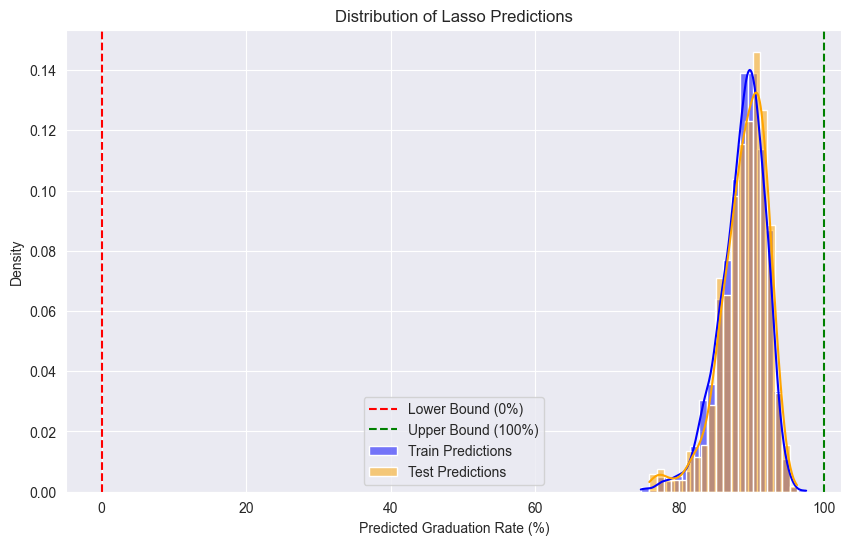

In [457]:
# get predictions for train and test data
train_predictions = lasso.predict(X_train)
test_predictions = lasso.predict(X_test)

# plot distribution for train predictions
plt.figure(figsize=(10, 6))
sns.histplot(train_predictions, bins=20, kde=True, color='blue', label='Train Predictions', stat="density")
sns.histplot(test_predictions, bins=20, kde=True, color='orange', label='Test Predictions', stat="density")

plt.axvline(0, color='red', linestyle='--', label='Lower Bound (0%)')
plt.axvline(100, color='green', linestyle='--', label='Upper Bound (100%)')
plt.xlabel('Predicted Graduation Rate (%)')
plt.ylabel('Density')
plt.title('Distribution of Lasso Predictions')
plt.legend()
plt.show()

plot residuals of lasso against the variable. looking at both the standardized versions of the independent variables (which are in per capita, except poverty/income/income range), and the absolute values of the variables

Residual Plots for Per Capita Variables


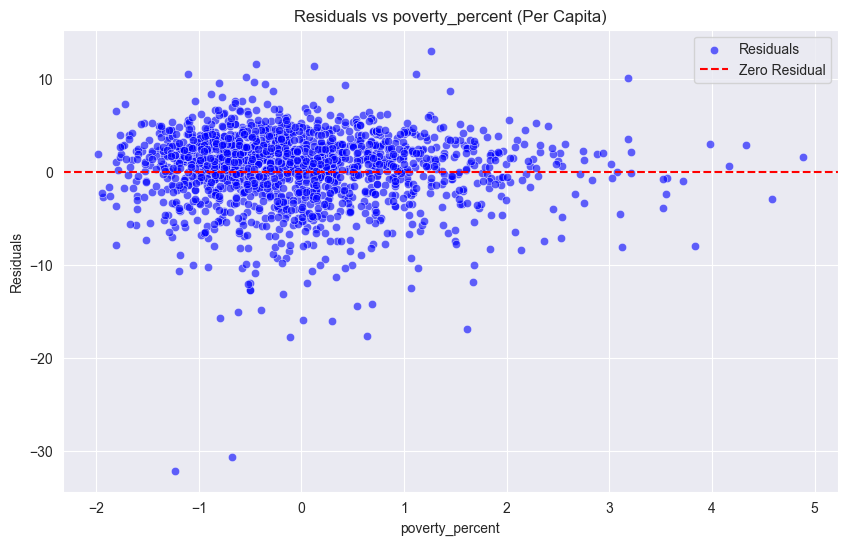

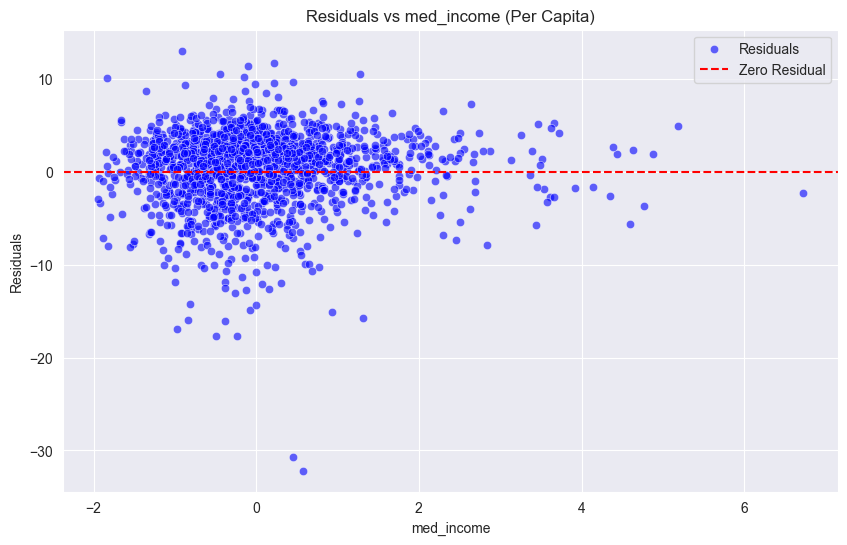

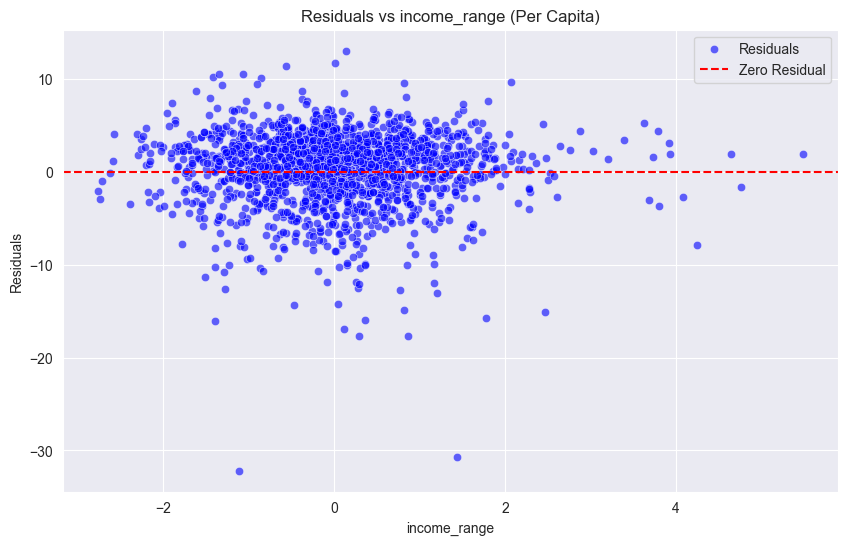

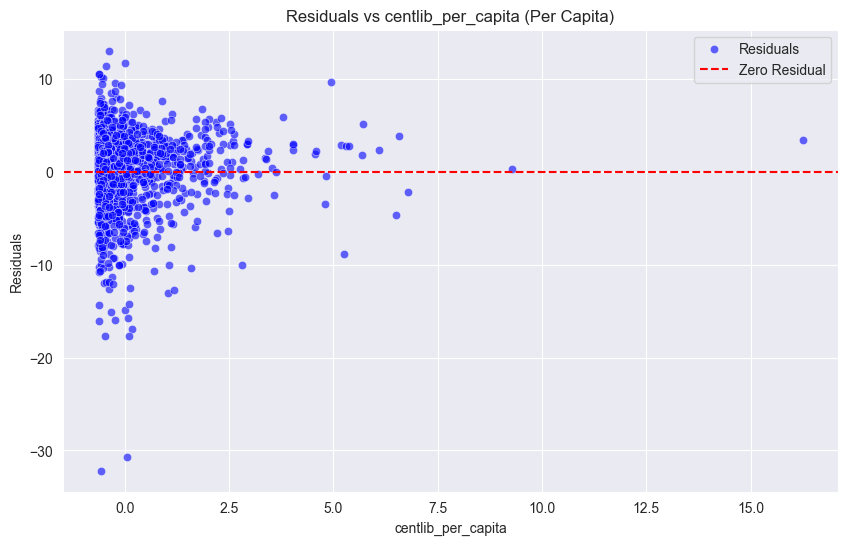

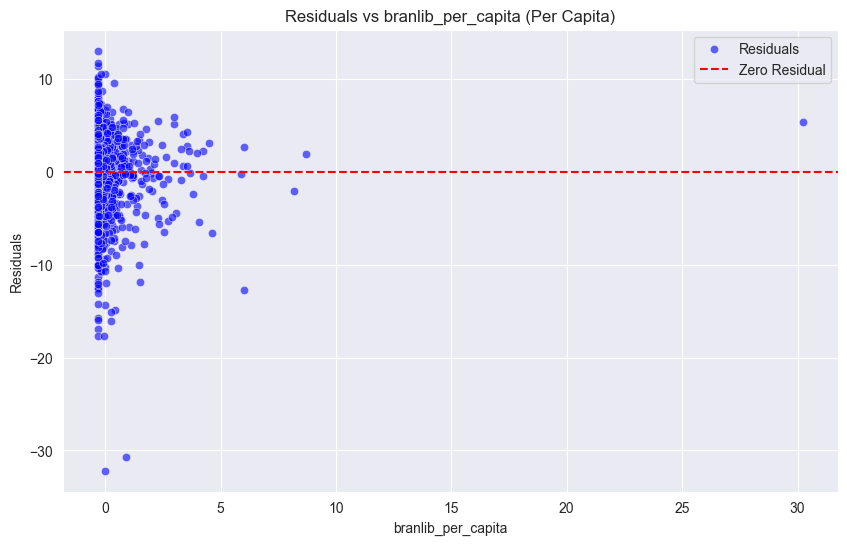

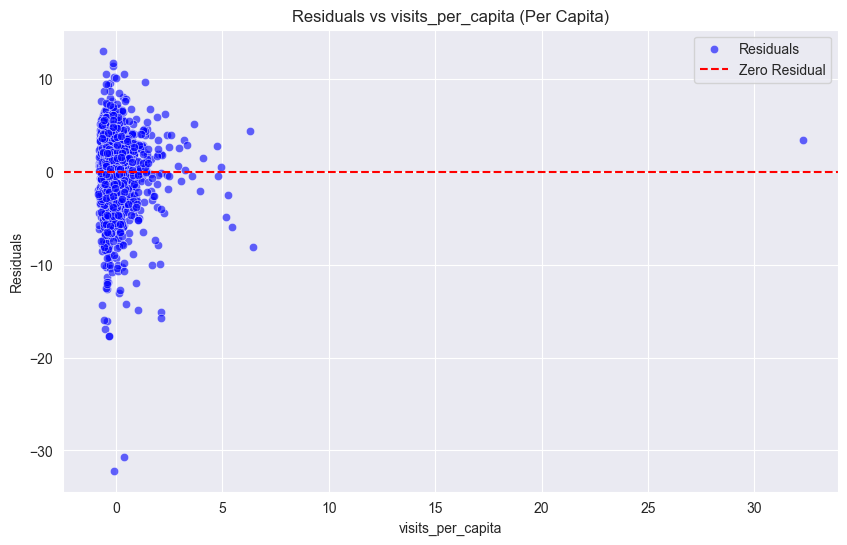

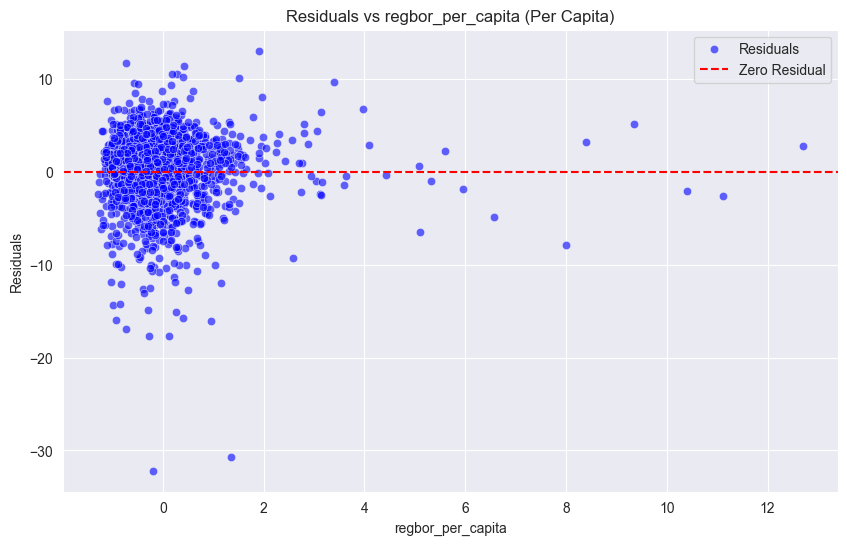

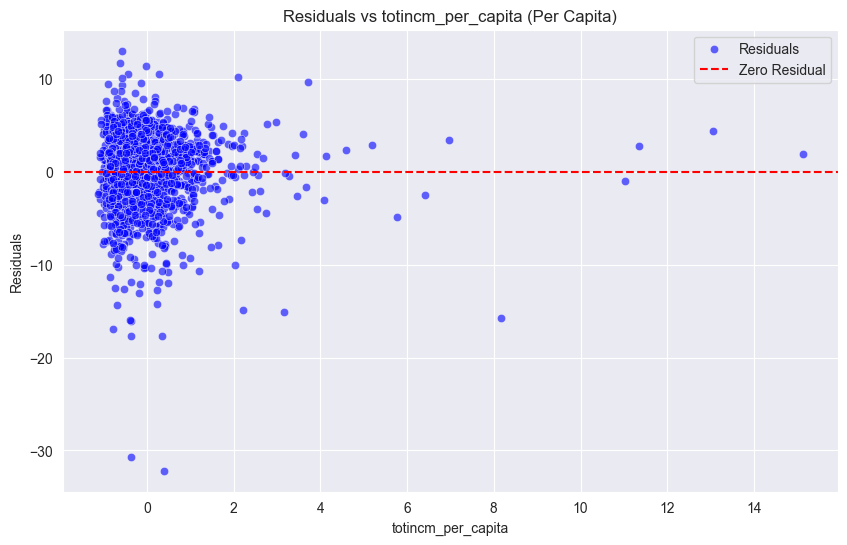

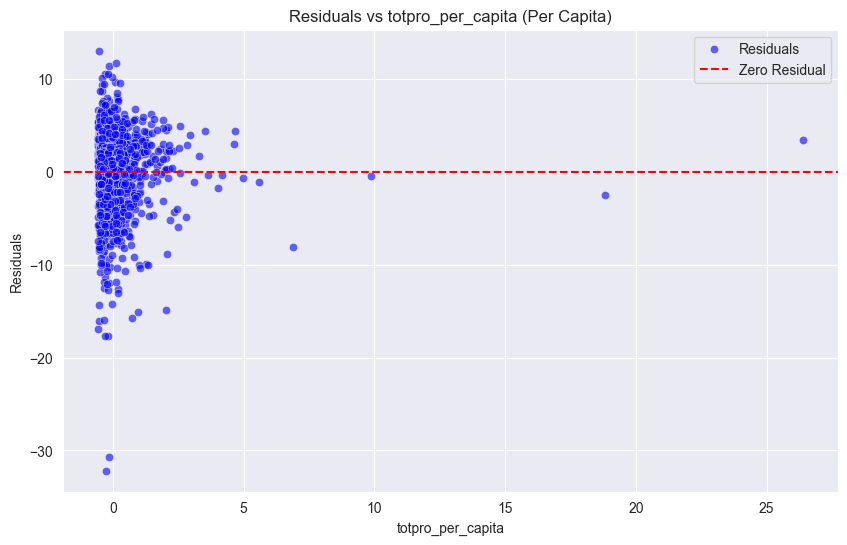

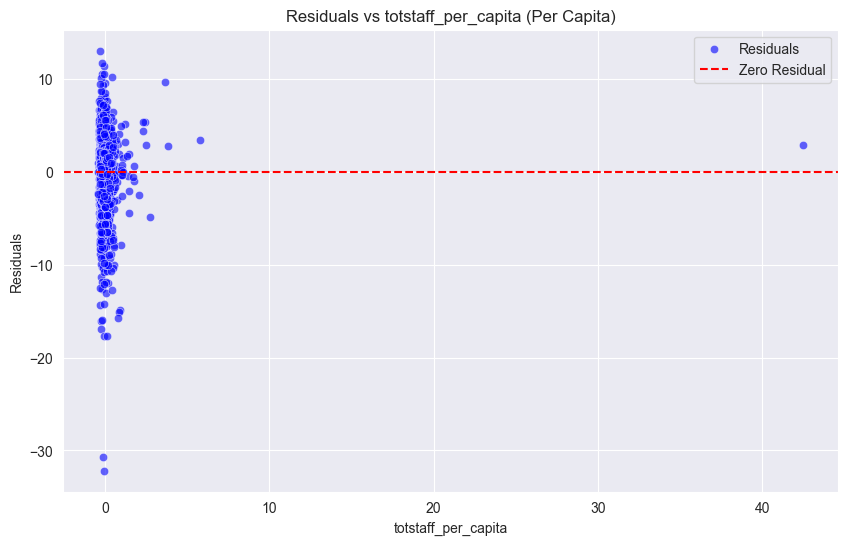

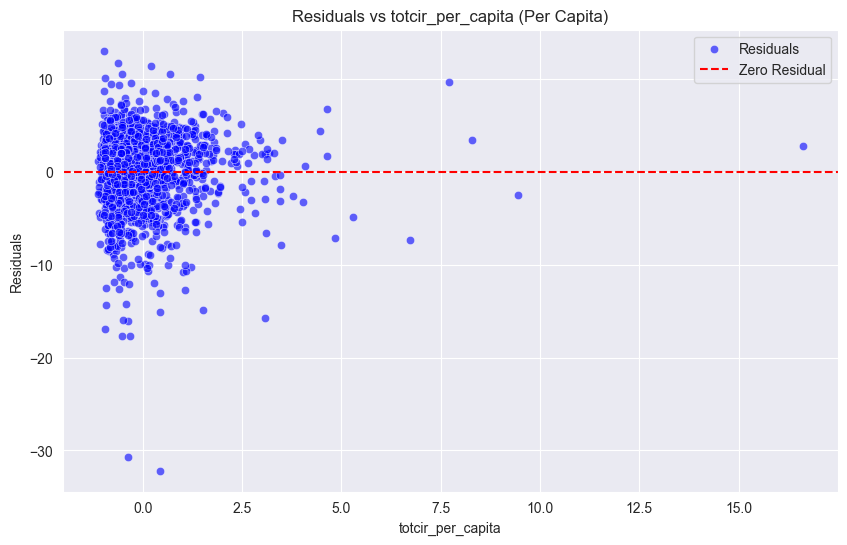

Residual Plots for Absolute Variables (including additional variables)


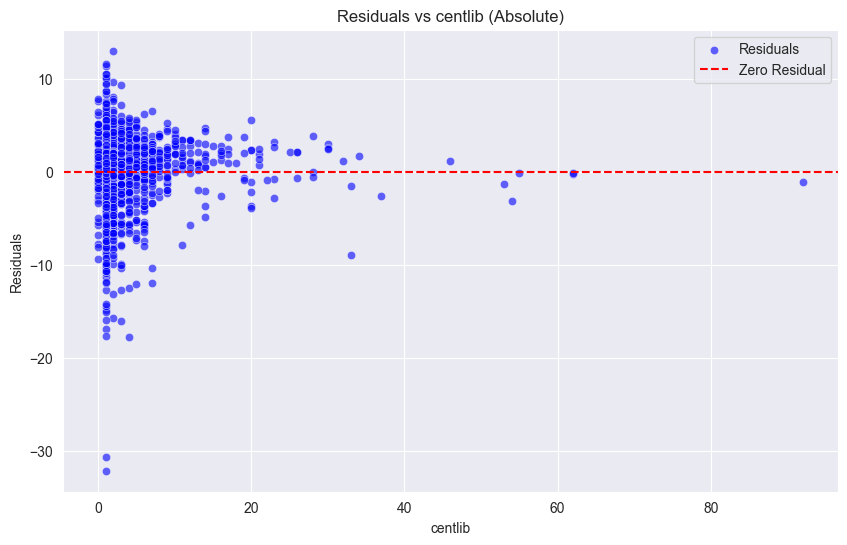

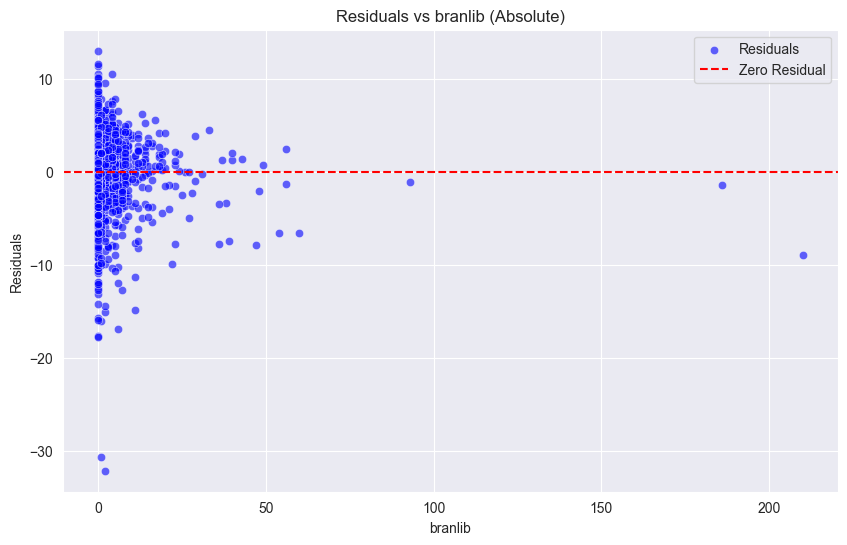

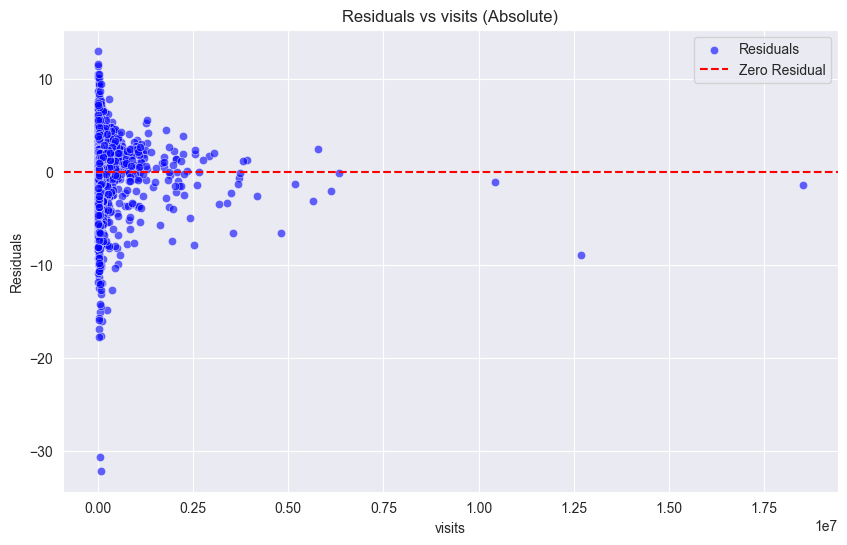

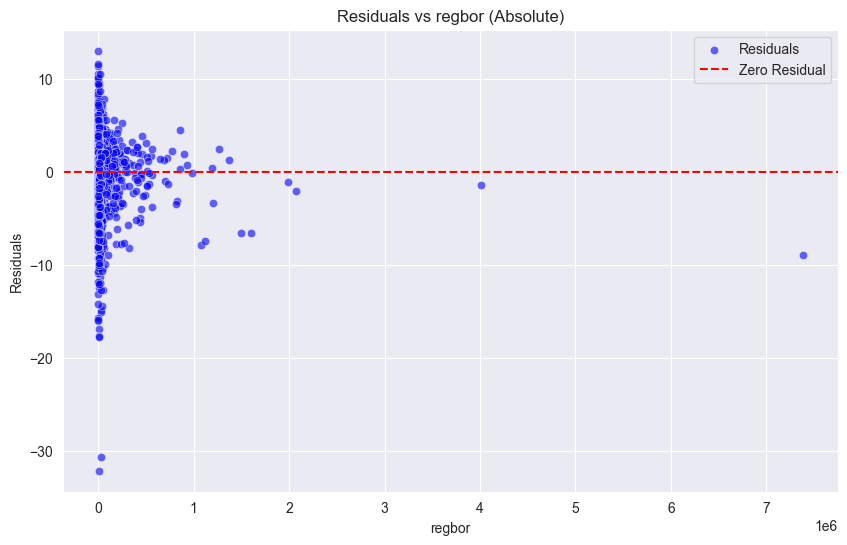

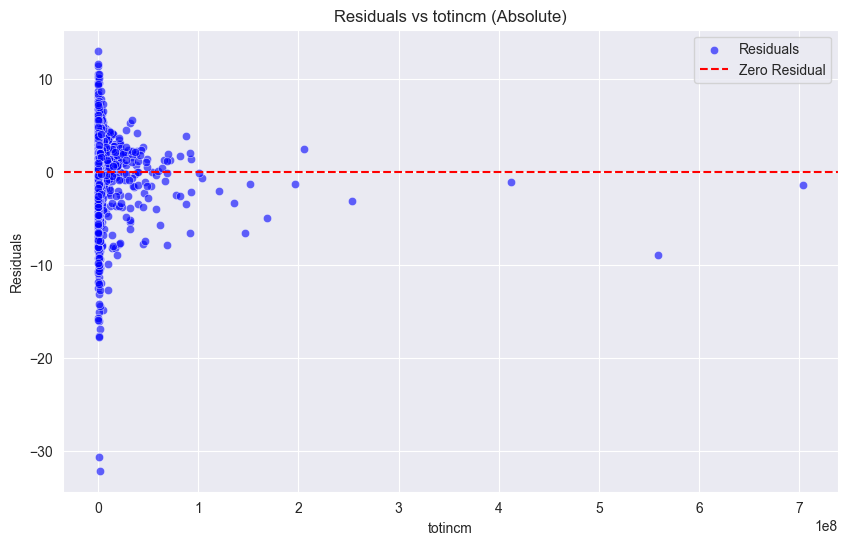

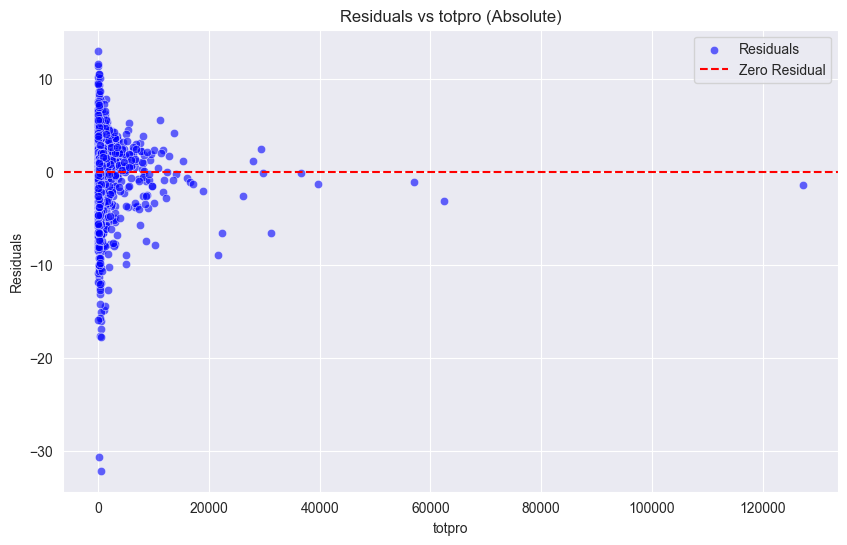

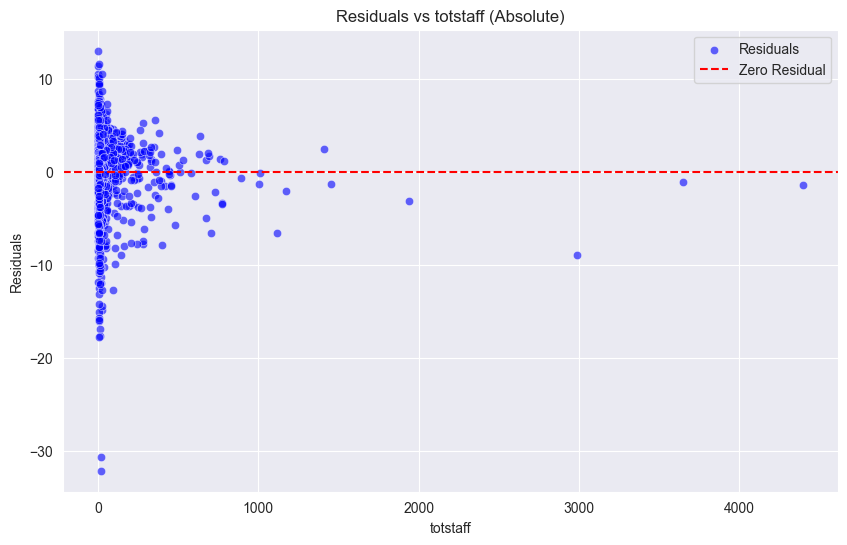

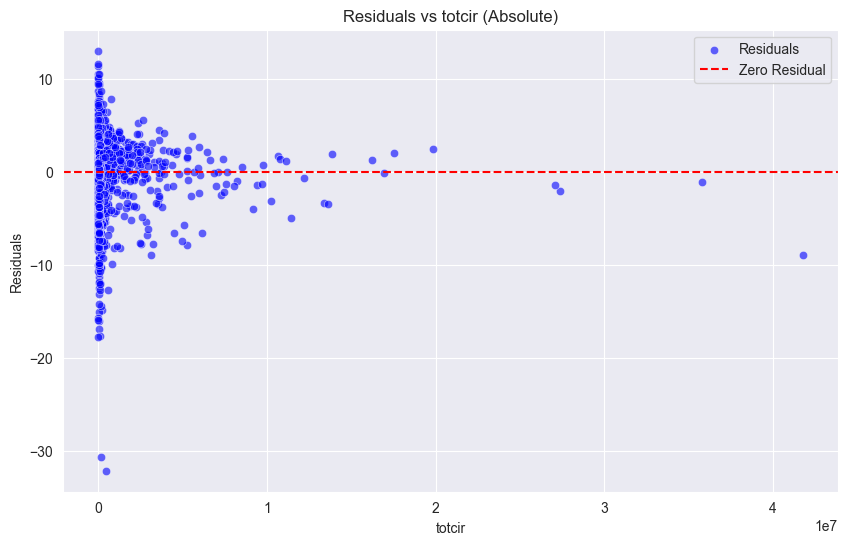

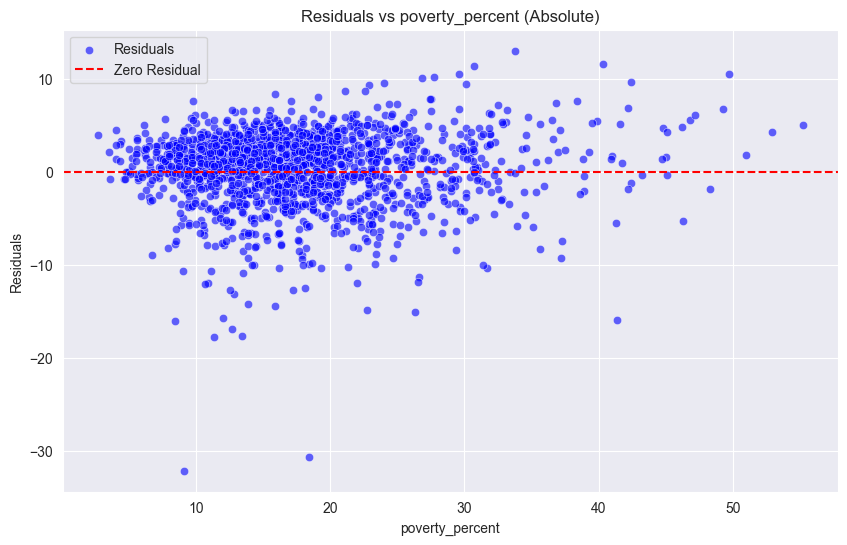

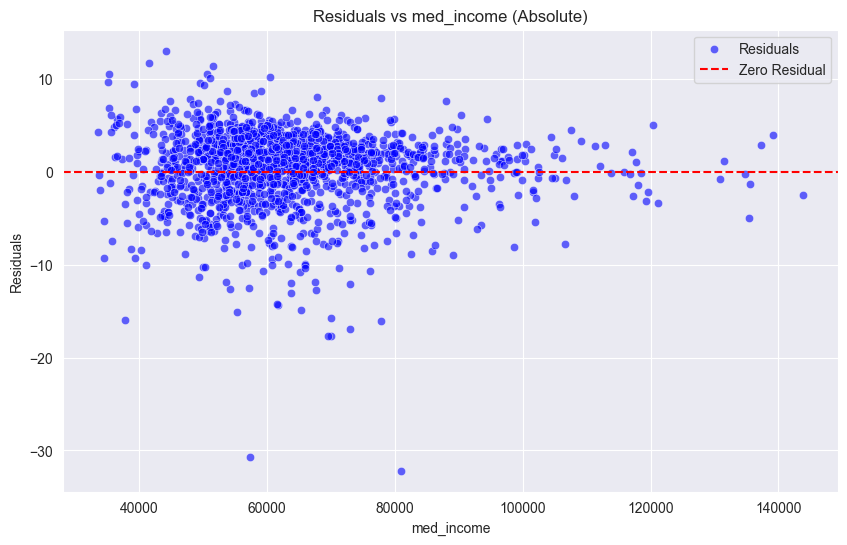

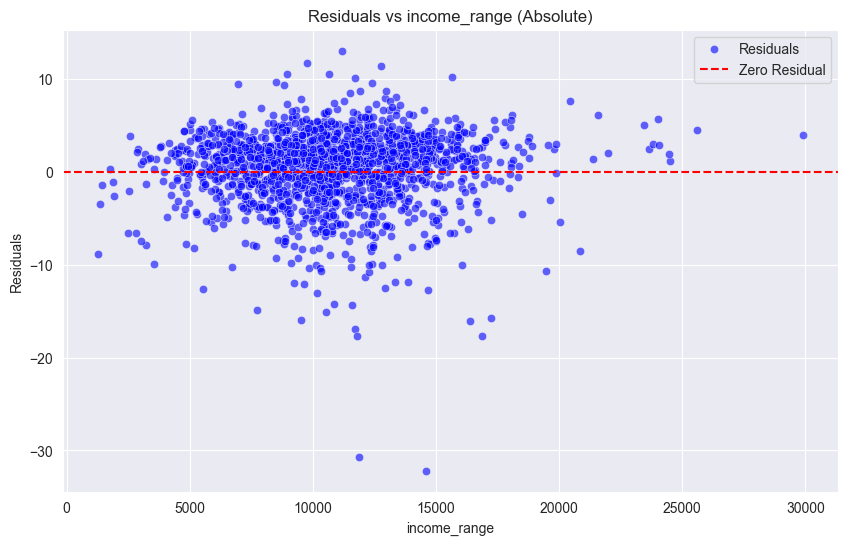

In [458]:
# function to plot residuals
def plot_residuals(X, residuals, title_suffix):
    for column in X.columns:
        plt.figure(figsize=(10, 6))
        
        sns.scatterplot(x=X[column], y=residuals, alpha=0.6, color='blue', label='Residuals')
        plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
        
        plt.xlabel(column)
        plt.ylabel('Residuals')
        plt.title(f'Residuals vs {column} ({title_suffix})')
        plt.legend()
        plt.show()

# calculate residuals
residuals_train = y_train - lasso_train_pred
residuals_test = y_test - lasso_test_pred

# combine scaled data with residuals for easier plotting
X_train_residuals = pd.DataFrame(X_train, columns=X.columns)
X_train_residuals['residuals'] = residuals_train

X_test_residuals = pd.DataFrame(X_test, columns=X.columns)
X_test_residuals['residuals'] = residuals_test

# first, plot residuals for per capita features
print("Residual Plots for Per Capita Variables")
plot_residuals(pd.DataFrame(X_train, columns=X.columns), residuals_train, title_suffix="Per Capita")

# use stored original columns for absolute value plots, including additional variables
absolute_X_train = original_columns.loc[X_train_residuals.index]
absolute_X_test = original_columns.loc[X_test_residuals.index]

# residual plots for absolute values
print("Residual Plots for Absolute Variables (including additional variables)")
plot_residuals(absolute_X_train, residuals_train, title_suffix="Absolute")

Performing lasso and ridge regressions on top-performing and bottom-performing counties based on high school graduation rates

Split data based off of top-performing % and bottom-performing % counties based on high school graduation rates 

In [459]:
# adjust these thresholds
# chose 15th and 85th percentiles after experimenting with different values
top_threshold = 0.15
bottom_threshold = 0.15

# calculate the 85th and 15th percentiles for grad_rate
top_percent_threshold = aggregated_df['grad_rate'].quantile(1 - top_threshold)  # 85th percentile
bottom_percent_threshold = aggregated_df['grad_rate'].quantile(bottom_threshold)  # 15th percentile

# filter top 15% and bottom 15% counties
top_percent = aggregated_df[aggregated_df['grad_rate'] >= top_percent_threshold]
bottom_percent = aggregated_df[aggregated_df['grad_rate'] < bottom_percent_threshold]

print("Top Performing Counties")
print(top_percent.sort_values(by='grad_rate', ascending=False).head(20))
print()
print("Bottom Performing Counties")
print(bottom_percent.sort_values(by='grad_rate', ascending=True).head(20))


X_top = top_percent.drop(columns=['STATE', 'COUNTY', 'grad_rate'])
y_top = top_percent['grad_rate']
X_bottom = bottom_percent.drop(columns=['STATE', 'COUNTY', 'grad_rate'])
y_bottom = bottom_percent['grad_rate']

# split into training and test sets for top and bottom groups
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y_top, test_size=0.2, random_state=42)
X_bottom_train, X_bottom_test, y_bottom_train, y_bottom_test = train_test_split(X_bottom, y_bottom, test_size=0.2, random_state=42)


Top Performing Counties
     STATE      COUNTY  grad_rate  poverty_percent  med_income  income_range  \
1470    ne        loup       98.9             27.7     60487.0       15638.0   
219     co    hinsdale       98.5             14.3     70675.0       18054.0   
218     co    gunnison       98.3              8.3     88855.0       11410.0   
248     co  san miguel       98.2              7.7     94387.0       24000.0   
240     co      pitkin       98.2              4.0    111291.0       27862.0   
2283    ut      morgan       98.2              3.1    119482.0       25012.0   
1464    ne   keya paha       98.1             30.7     51579.0       12748.0   
210     co     douglas       97.9              2.1    140768.0        8368.0   
1546    nm  los alamos       97.9              2.7    139217.0       29886.0   
1428    ne      cherry       97.8             15.9     58017.0       11518.0   
5       ak      haines       97.7             16.9     70610.0       15832.0   
2439    wi     o

compare distribution of features for the top vs bottom counties

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


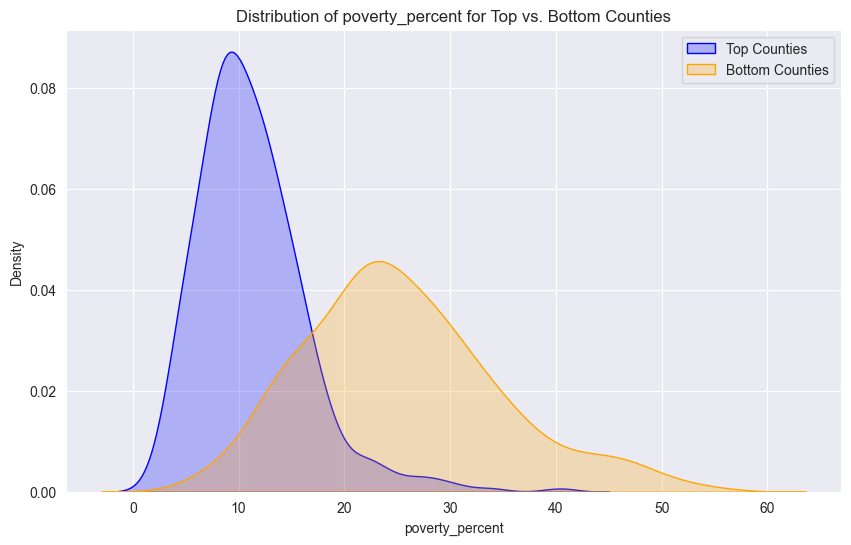

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


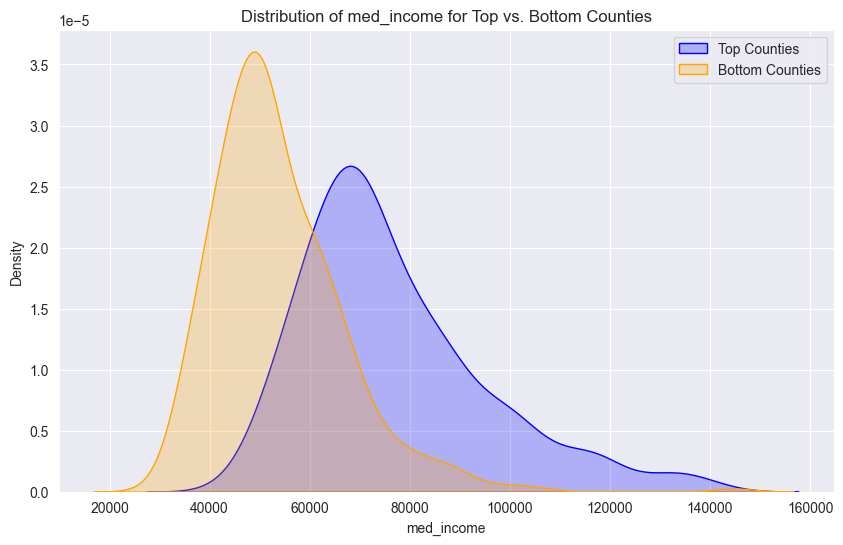

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


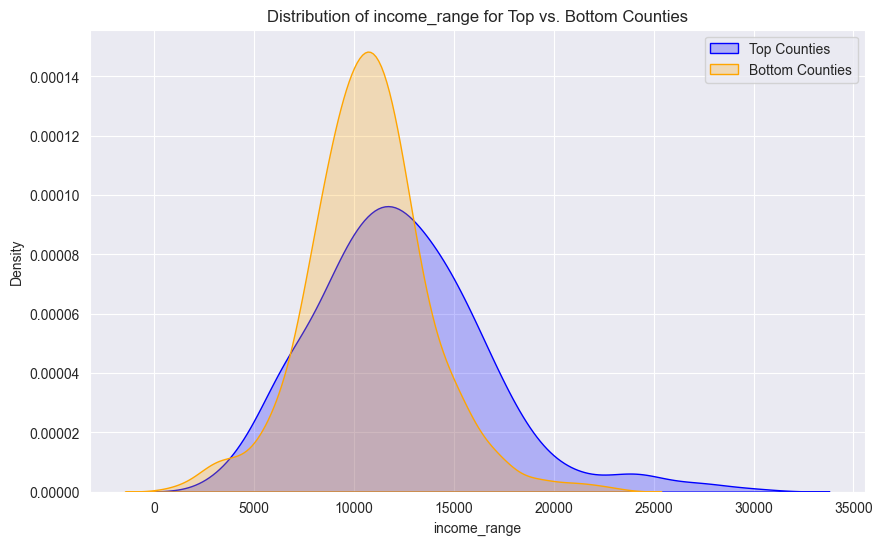

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


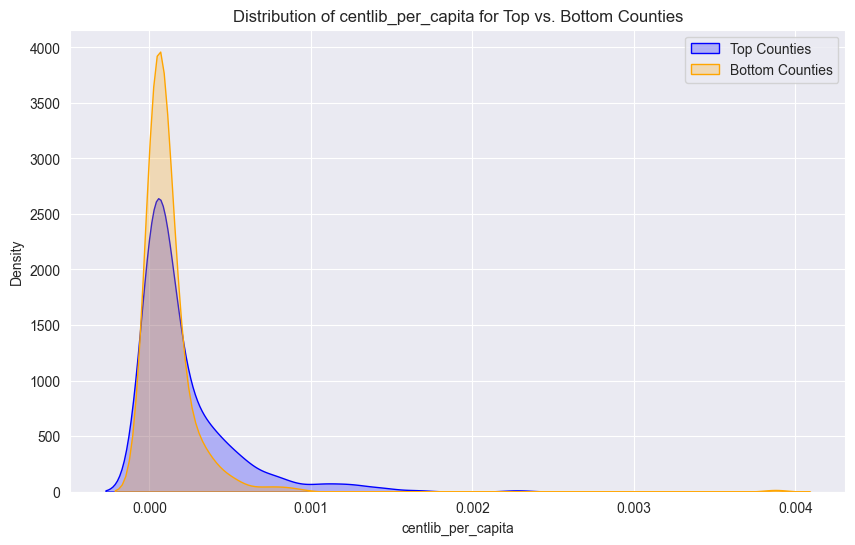

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


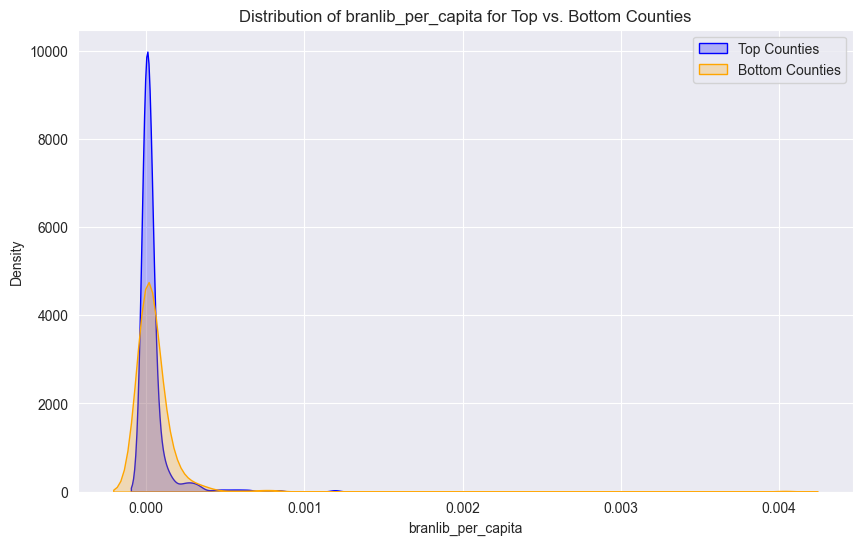

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


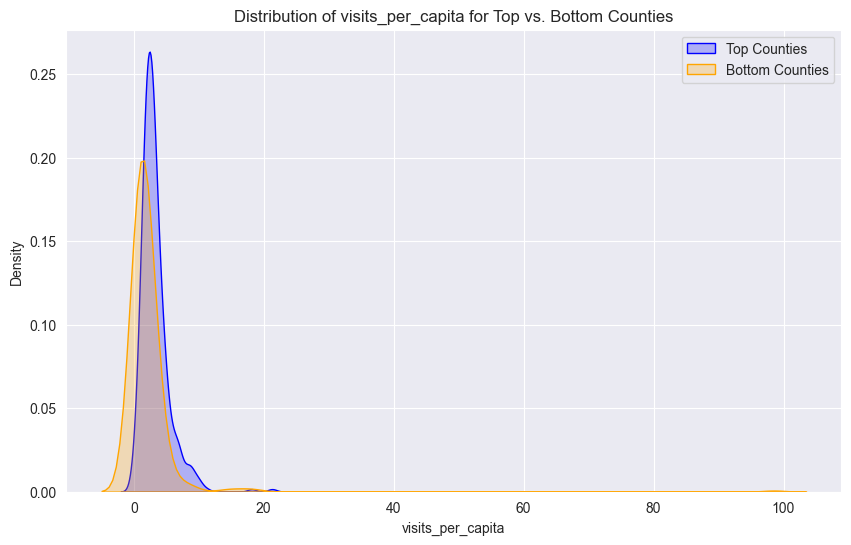

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


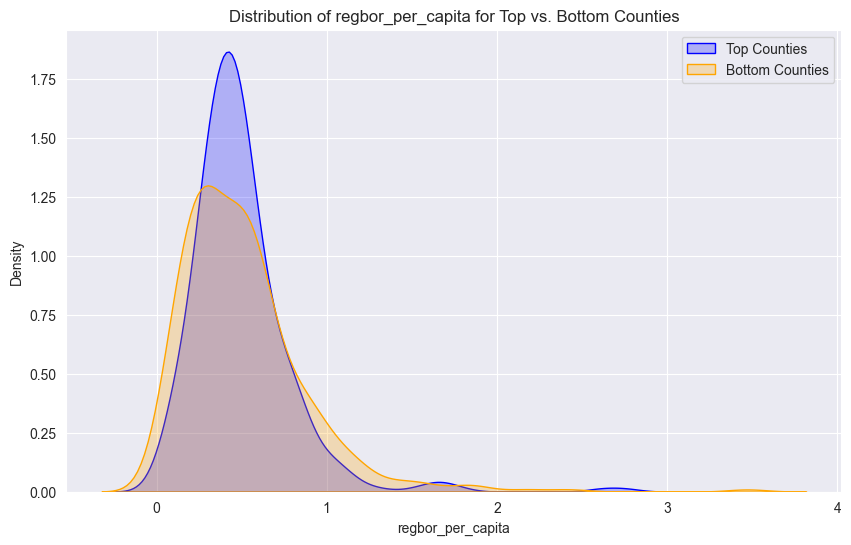

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


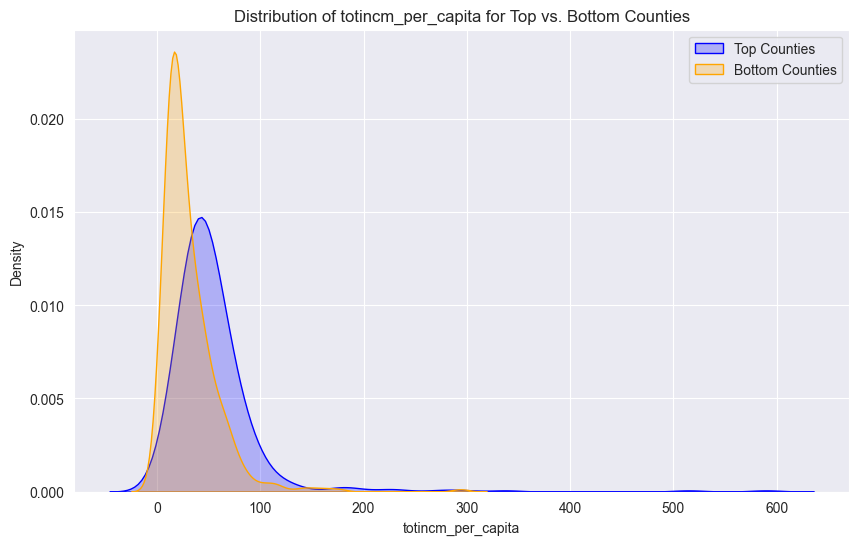

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


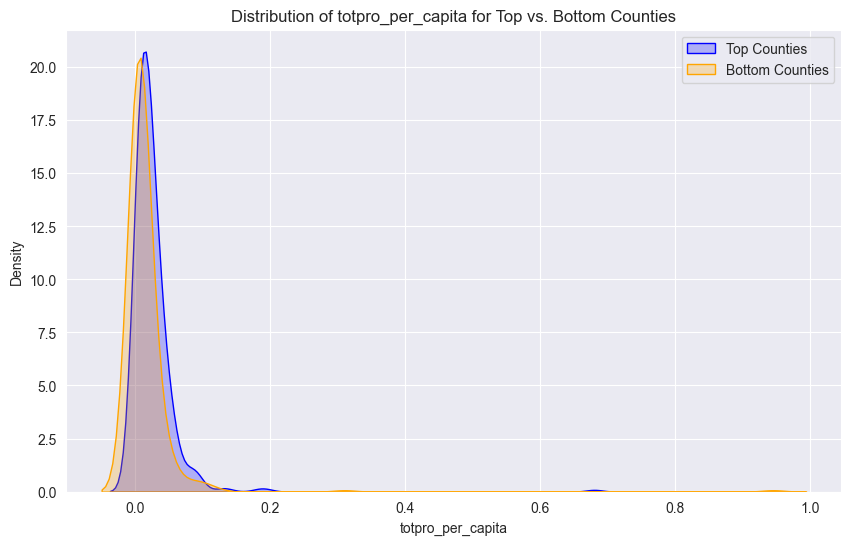

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


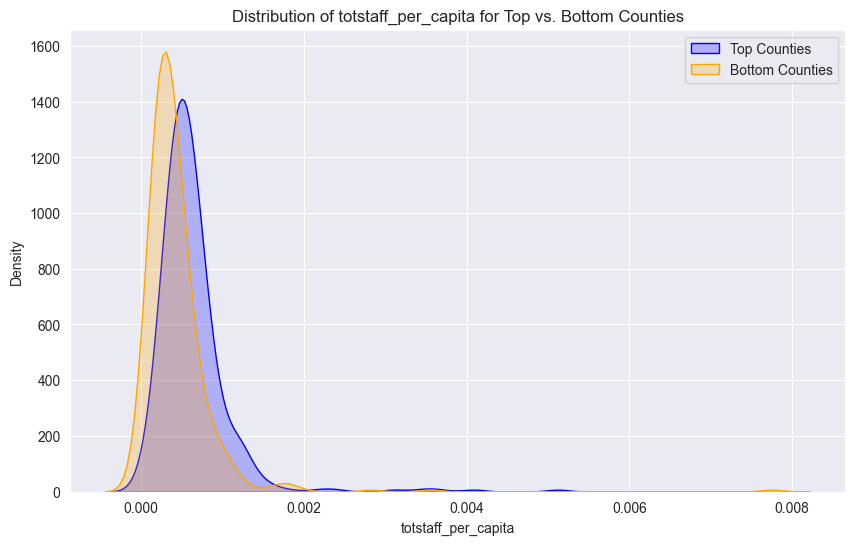

C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
C:\Users\Chris\AppData\Local\Temp\ipykernel_11556\35074638.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')


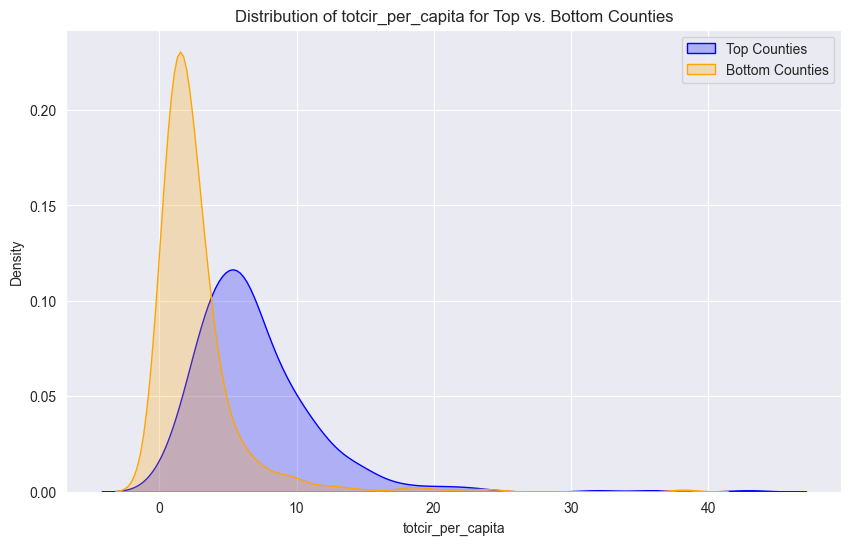

In [460]:
# plot distributions for each feature
for feature in X_top.columns:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(X_top[feature], label='Top Counties', shade=True, color='blue')
    sns.kdeplot(X_bottom[feature], label='Bottom Counties', shade=True, color='orange')
    
    plt.title(f'Distribution of {feature} for Top vs. Bottom Counties')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

analyze correlation matrices for the top versus bottom

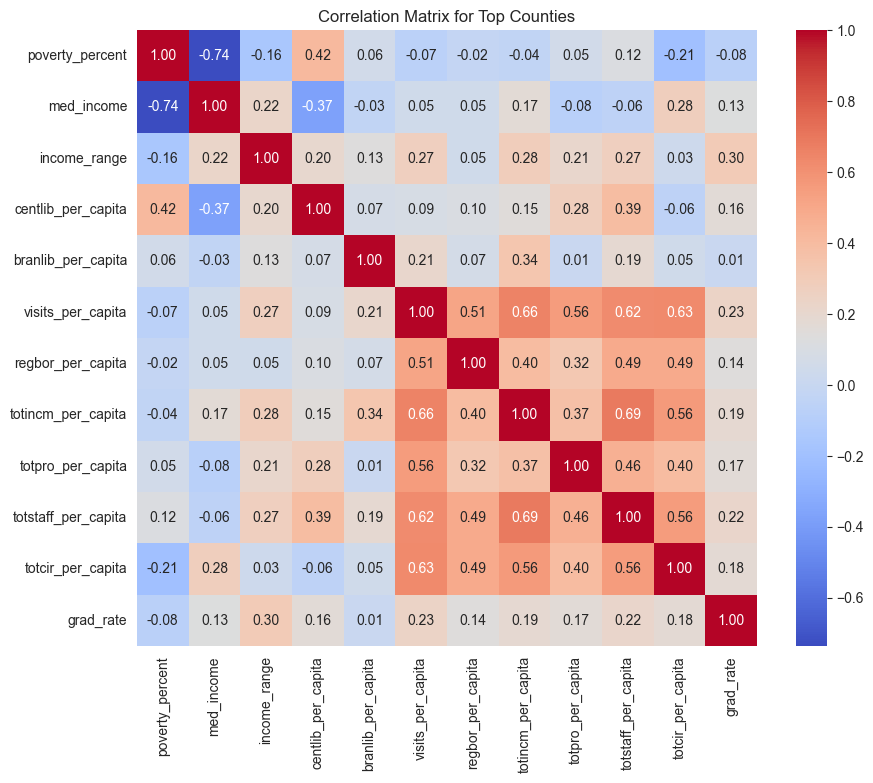

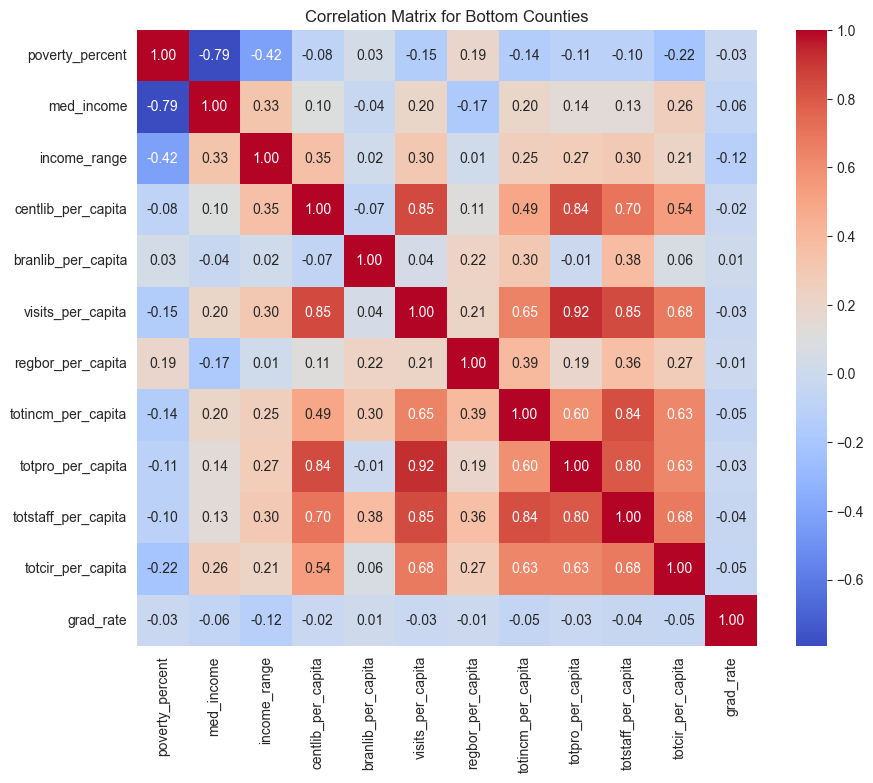

In [461]:
 # include grad_rate in X_top and X_bottom for correlation
X_top_combined = pd.concat([X_top, y_top], axis=1)
X_bottom_combined = pd.concat([X_bottom, y_bottom], axis=1)

# compute correlation matrices
corr_top = X_top_combined.corr()
corr_bottom = X_bottom_combined.corr()

# plot the correlation matrices
plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Top Counties")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_bottom, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Bottom Counties")
plt.show()


perform regressions for top versus bottom thresholds

In [462]:
# scale the data for both subsets
X_top_scaled = scaler.fit_transform(X_top)
X_bottom_scaled = scaler.fit_transform(X_bottom)

# lasso regression for top %
lasso_top = LassoCV(alphas=np.logspace(-4, 4, 100), cv=20, random_state=42)
lasso_top.fit(X_top_scaled, y_top)

# lasso regression for bottom %
lasso_bottom = LassoCV(alphas=np.logspace(-4, 4, 100), cv=20, random_state=42)
lasso_bottom.fit(X_bottom_scaled, y_bottom)

# ridge regression for top %
ridge_top = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=20)
ridge_top.fit(X_top_scaled, y_top)

# ridge regression for bottom %
ridge_bottom = RidgeCV(alphas=np.logspace(-4, 4, 100), cv=20)
ridge_bottom.fit(X_bottom_scaled, y_bottom)

top_percent = int(top_threshold * 100)
bottom_percent = int(bottom_threshold * 100)

# define alpha range for lasso and ridge
alpha_range = np.logspace(-4, 4, 100)

# train lasso and ridge models for top and bottom subsets
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model_type, alpha_range):
    # define pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_type, LassoCV(alphas=alpha_range, cv=20, random_state=42) if model_type == 'lasso' else RidgeCV(alphas=alpha_range, cv=20))
    ])
    
    # train model
    pipeline.fit(X_train, y_train)
    
    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    # calculate mse
    mse = mean_squared_error(y_test, y_pred)
    
    # extract coefficients
    model = pipeline.named_steps[model_type]
    weights_df = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': model.coef_
    }).sort_values(by='coefficient', key=abs, ascending=False)
    
    return pipeline, mse, weights_df


# top counties
lasso_top_pipeline, lasso_top_mse, lasso_top_weights = train_and_evaluate_model(X_top_train, X_top_test, y_top_train, y_top_test, 'lasso', alpha_range)
ridge_top_pipeline, ridge_top_mse, ridge_top_weights = train_and_evaluate_model(X_top_train, X_top_test, y_top_train, y_top_test, 'ridge', alpha_range)

# bottom counties
lasso_bottom_pipeline, lasso_bottom_mse, lasso_bottom_weights = train_and_evaluate_model(X_bottom_train, X_bottom_test, y_bottom_train, y_bottom_test, 'lasso', alpha_range)
ridge_bottom_pipeline, ridge_bottom_mse, ridge_bottom_weights = train_and_evaluate_model(X_bottom_train, X_bottom_test, y_bottom_train, y_bottom_test, 'ridge', alpha_range)

# corrected print statements
print(f"top {int((1 - top_threshold) * 100)}% (top-performing counties) - lasso regression")
print(f"best alpha: {lasso_top_pipeline.named_steps['lasso'].alpha_}")
print(lasso_top_weights)
print(f"mse (top {int((1 - top_threshold) * 100)}% - lasso): {lasso_top_mse}")

print(f"bottom {int(bottom_threshold * 100)}% (bottom-performing counties) - lasso regression")
print(f"best alpha: {lasso_bottom_pipeline.named_steps['lasso'].alpha_}")
print(lasso_bottom_weights)
print(f"mse (bottom {int(bottom_threshold * 100)}% - lasso): {lasso_bottom_mse}")

print(f"top {int((1 - top_threshold) * 100)}% (top-performing counties) - ridge regression")
print(f"best alpha: {ridge_top_pipeline.named_steps['ridge'].alpha_}")
print(ridge_top_weights)
print(f"mse (top {int((1 - top_threshold) * 100)}% - ridge): {ridge_top_mse}")

print(f"bottom {int(bottom_threshold * 100)}% (bottom-performing counties) - ridge regression")
print(f"best alpha: {ridge_bottom_pipeline.named_steps['ridge'].alpha_}")
print(ridge_bottom_weights)
print(f"mse (bottom {int(bottom_threshold * 100)}% - ridge): {ridge_bottom_mse}")

top 85% (top-performing counties) - lasso regression
best alpha: 0.055908101825122285
                feature  coefficient
2          income_range     0.197750
3    centlib_per_capita     0.121547
1            med_income     0.097454
5     visits_per_capita     0.065464
10    totcir_per_capita     0.034611
9   totstaff_per_capita     0.028492
8     totpro_per_capita     0.011654
0       poverty_percent    -0.000000
4    branlib_per_capita    -0.000000
6     regbor_per_capita     0.000000
7    totincm_per_capita     0.000000
mse (top 85% - lasso): 1.0668867865209304
bottom 15% (bottom-performing counties) - lasso regression
best alpha: 0.06734150657750829
                feature  coefficient
0       poverty_percent    -0.743188
2          income_range    -0.617222
1            med_income    -0.484054
3    centlib_per_capita     0.178806
10    totcir_per_capita    -0.134625
7    totincm_per_capita    -0.092002
4    branlib_per_capita     0.000000
5     visits_per_capita     0.000000
6   

compare distribution of residuals

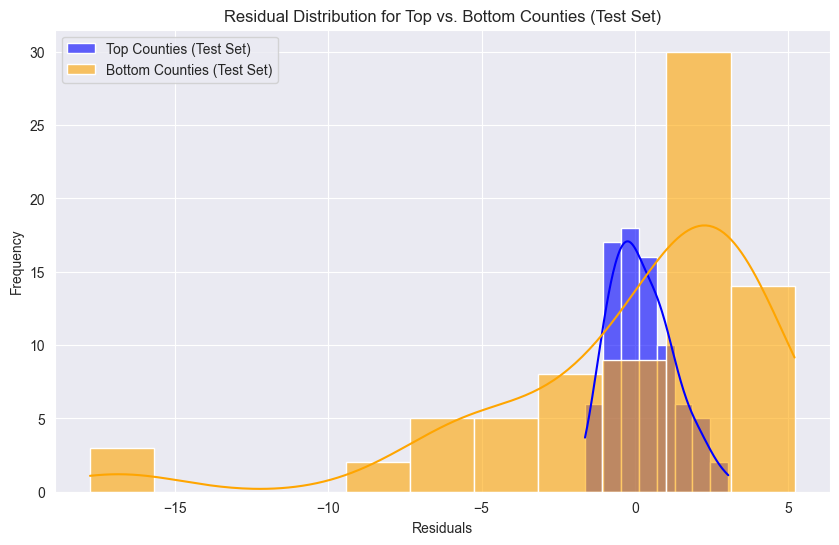

In [463]:
# residuals for both models on the test set
residuals_top_test = y_top_test - lasso_top_pipeline.predict(X_top_test)
residuals_bottom_test = y_bottom_test - lasso_bottom_pipeline.predict(X_bottom_test)

# plot residuals for each group
plt.figure(figsize=(10, 6))
sns.histplot(residuals_top_test, kde=True, label='Top Counties (Test Set)', color='blue', alpha=0.6)
sns.histplot(residuals_bottom_test, kde=True, label='Bottom Counties (Test Set)', color='orange', alpha=0.6)
plt.title('Residual Distribution for Top vs. Bottom Counties (Test Set)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()